<a href="https://colab.research.google.com/github/arizonaCameraLab/computationalImaging/blob/master/waves/ptychographyAndWaveCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ptychography
## Chengyu Wang and David Brady
## University of Arizona
## October 2021

This notebook presents concepts in ptychographic imaging as discussed in section 5.11 of *Computational Imaging*.

### Python Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
from joblib import Parallel, delayed
import time
from skimage import exposure, filters
from skimage.metrics import structural_similarity as ssim
#from google.colab import files
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['font.size']= 22

### Test image

In [120]:
#!wget --no-check-certificate --content-disposition 'https://github.com/djbradyAtOpticalSciencesArizona/computationalImaging/raw/master/images/sample.png'
!wget --no-check-certificate --content-disposition 'https://github.com/djbradyAtOpticalSciencesArizona/computationalImaging/raw/master/images/snake.npy'

--2024-05-02 09:38:58--  https://github.com/djbradyAtOpticalSciencesArizona/computationalImaging/raw/master/images/snake.npy
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/djbradyAtOpticalSciencesArizona/computationalImaging/master/images/snake.npy [following]
--2024-05-02 09:38:59--  https://raw.githubusercontent.com/djbradyAtOpticalSciencesArizona/computationalImaging/master/images/snake.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8388736 (8.0M) [application/octet-stream]
Saving to: ‘snake.npy’

snake.npy           100%[===================>]   8.00M  --.-KB/s    in 0.1s    

2024-05-0

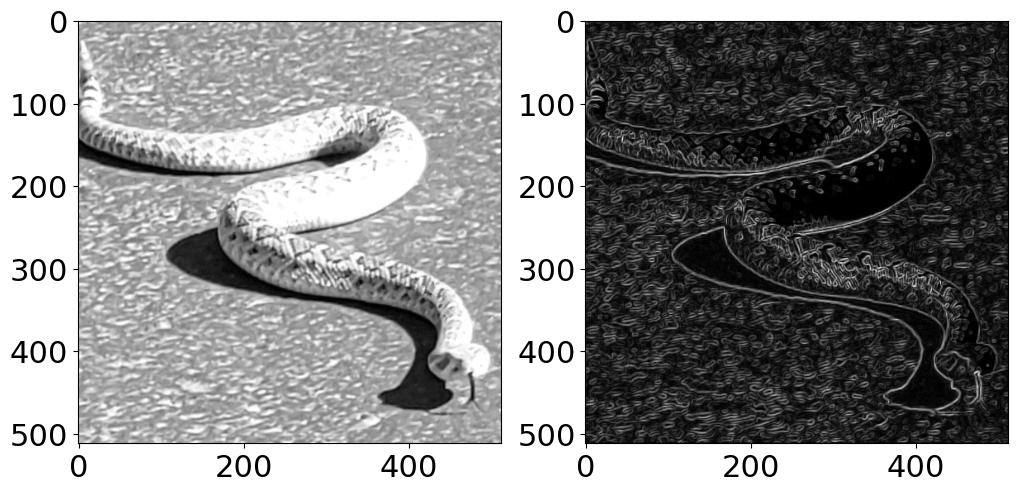

In [121]:
#im = cv2.imread('sample.png',0)/255
im = np.load('snake.npy')
im=im-np.mean(im)
im=im[300:812,270:782]
plt.figure(figsize= (12,6))
imf=filters.roberts(im)
plt.subplot(1,2,1)
plt.imshow(im,cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(imf,cmap = 'gray')


This is the test image. One might also consider using a high pass filtered version to focus more on high frequencies. Of course, if the object were a phase object there might also be substantial high frequency information. We have also made the image zero mean to reduce the low frequency signal.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

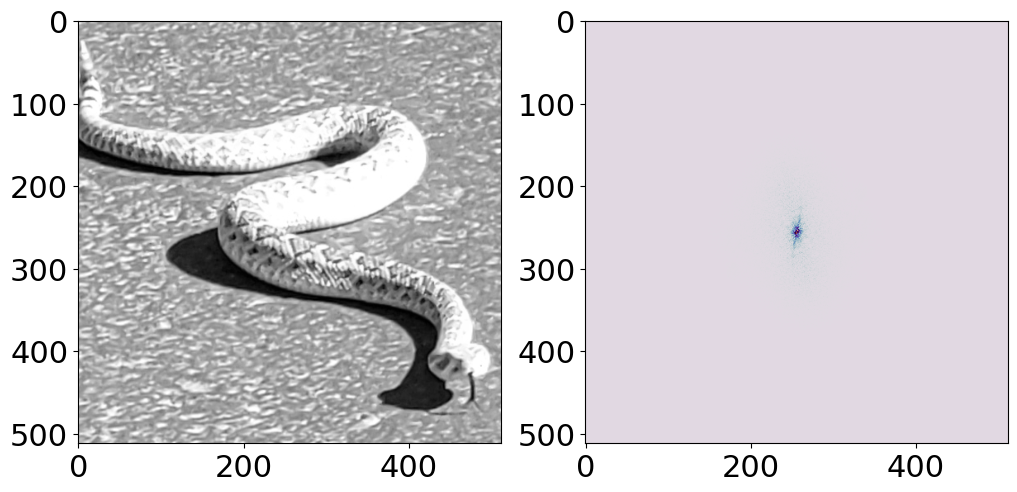

In [ ]:
#im = cv2.imread('sample.png',0)/255
plt.figure(figsize= (12,6))
imfT=np.fft.fftshift(np.fft.fft2(im))
plt.subplot(1,2,1)
plt.imshow(im,cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(np.abs(imfT),cmap = 'twilight')
plt.savefig('fpImage.pdf')
files.download('fpImage.pdf')

## Ptychographic Sampling

We first seek to illustrate sampling in real space ptychography. The forward model is
$$
\begin{array}{rl}
     g(u',v',x',y')&=|{\cal F}\lbrace f(x,y)P(x-x',y-y')\rbrace |^2 \\
     & =|\int\int e^{2\pi i (ux'+vy')}{\hat f}(u,v){\hat P}(u'-u,v'-v)dudv |^2
\end{array}
$$

In [ ]:
## PUPIL
def get_pupil(apD):
    # apD: diameter of the aperture
    # returns an array apD by apD array enclosing an circular aperture of radius apD/a
    r = apD/2
    y,x = np.ogrid[-r+0.5: r:1, -r+0.5: r]
    disk = x**2+y**2 <= r**2
    disk = disk.astype(float)
    return disk

In [ ]:
512+256

768

We consider circular samples of size 128 on a 512 pixel image and look at the sample structure in Fourier space.

In [123]:
def pyMeasurement(x,y, im):
  # multiply a N by N image by a 128 diameter aperture centered at x,y, return the fourier transformation
  mask=np.zeros(im.shape)
  mask[(x-64):(x+64),(y-64):(y+64)]=get_pupil(128)
  gx=mask*im
  gu=np.abs(np.fft.fftshift(np.fft.fft2(gx)))**2
  return gx, gu

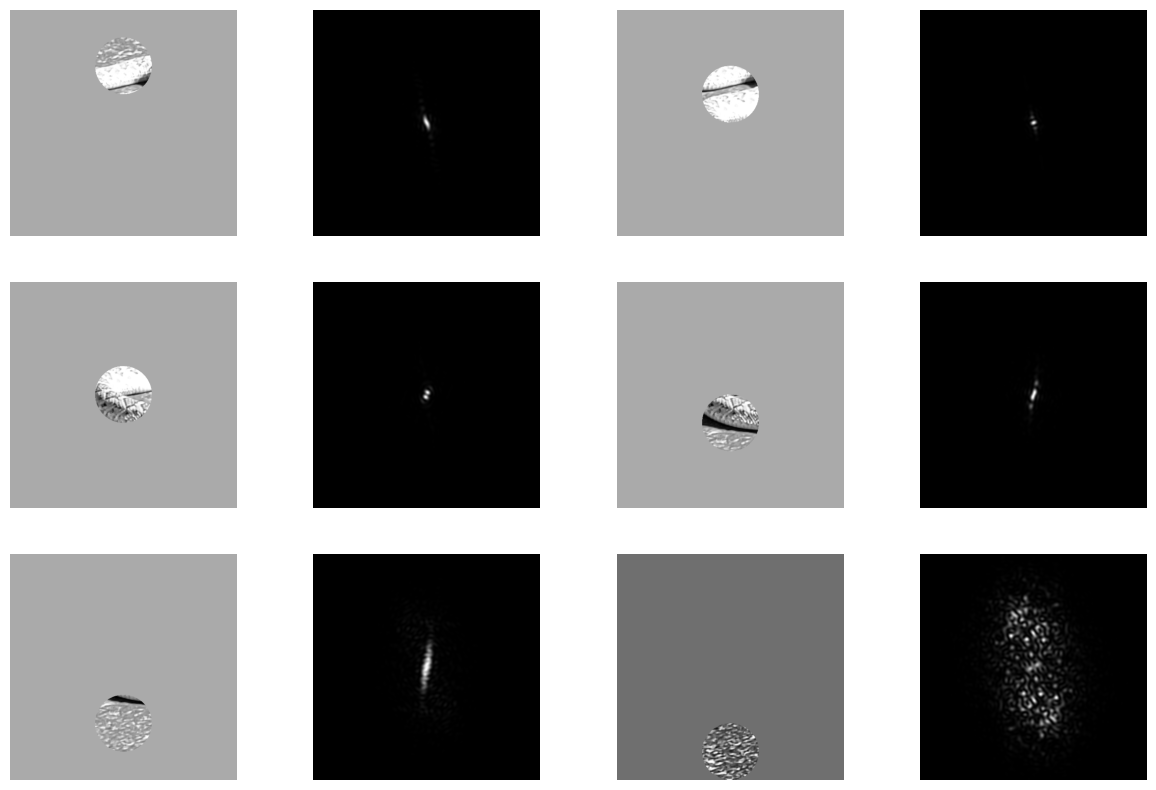

In [127]:
imP=np.pad(im,256)
plt.figure(figsize= (15,10))
for pip in range(6):
  a,b= pyMeasurement(pip*64+256+128,512,imP)
  plt.subplot(3,4,2*pip+1)
  plt.imshow(a[256:768,256:768], cmap='gray')
  plt.axis('off')
  plt.subplot(3,4,2*pip+2)
  plt.imshow(b[256:768,256:768], cmap='gray')
  plt.axis('off')
plt.savefig('ptySampling.pdf')
#files.download('ptySampling.pdf')

Alternatively, with Fourier ptychography, we apply the aperture in fourier space and consider the real space spectrogram. The forward model in this case is \begin{equation}
\begin{array}{rl}
     g(x',y',u',v')&=|{\cal F}^{-1}\lbrace {\hat f}(u,v)P(u-u',v-v')\rbrace |^2 \\
     & =|\int\int e^{2\pi i (u'x+v'y)}f(x,y)h(x'-x,y'-y)dxdy |^2
\end{array}
\end{equation}
here is an example set of measurements in this case:


In [128]:
def pyMeasurement(x,y, im):
  # multiply a N by N image by a 128 diameter aperture centered at x,y, return the fourier transformation
  mask=np.zeros(im.shape)
  mask[(x-64):(x+64),(y-64):(y+64)]=get_pupil(128)
  gx=mask*im
  gu=np.abs(np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(gx))))**2
  return gx, gu

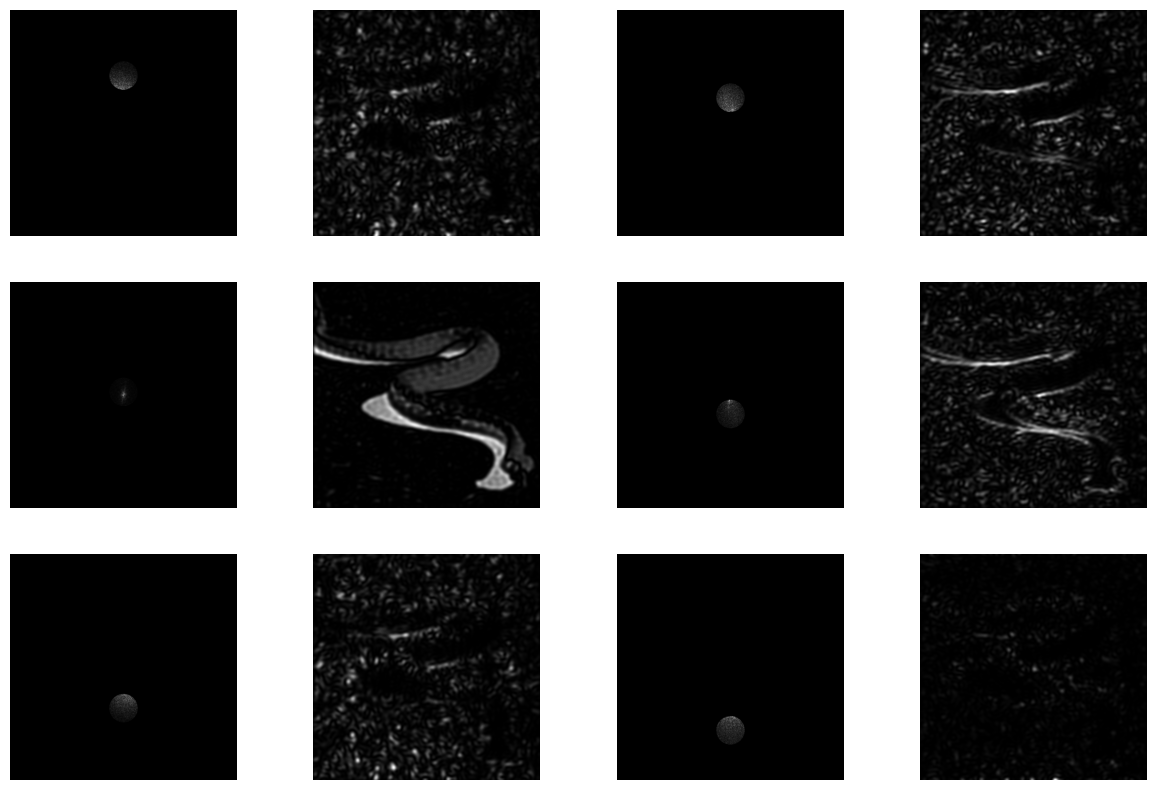

In [129]:
plt.figure(figsize= (15,10))
imFT=np.fft.fftshift(np.fft.fft2(np.fft.fftshift(imP)))
for pip in range(6):
  a,b= pyMeasurement(pip*100+300,512,imFT)
  plt.subplot(3,4,2*pip+1)
  plt.imshow(np.abs(a), cmap='gray')
  plt.axis('off')
  plt.subplot(3,4,2*pip+2)
  plt.imshow(b[256:768,256:768], cmap='gray')
  plt.axis('off')
plt.savefig('fpSampling.pdf')
#files.download('fpSampling.pdf')

# Fourier Ptychography

In [131]:
photons = 1e2
is_noisy = True

In [130]:
input_dim = 512     # image dimension (512,512)
pad = 8 + 25       # Adding padding to the fourier space
measure_dim = 128     # diameter of the aperture
spacing = int(np.round(128 * (1-0.61)))   # spacing between apertures, ensure 61% overlap

#### Fourier ptychography measures the spectrogram of an image with a shifting low pass filter. Here each circle represents an aperture location in Fourier Space. The square represents the Fourier transform of the image

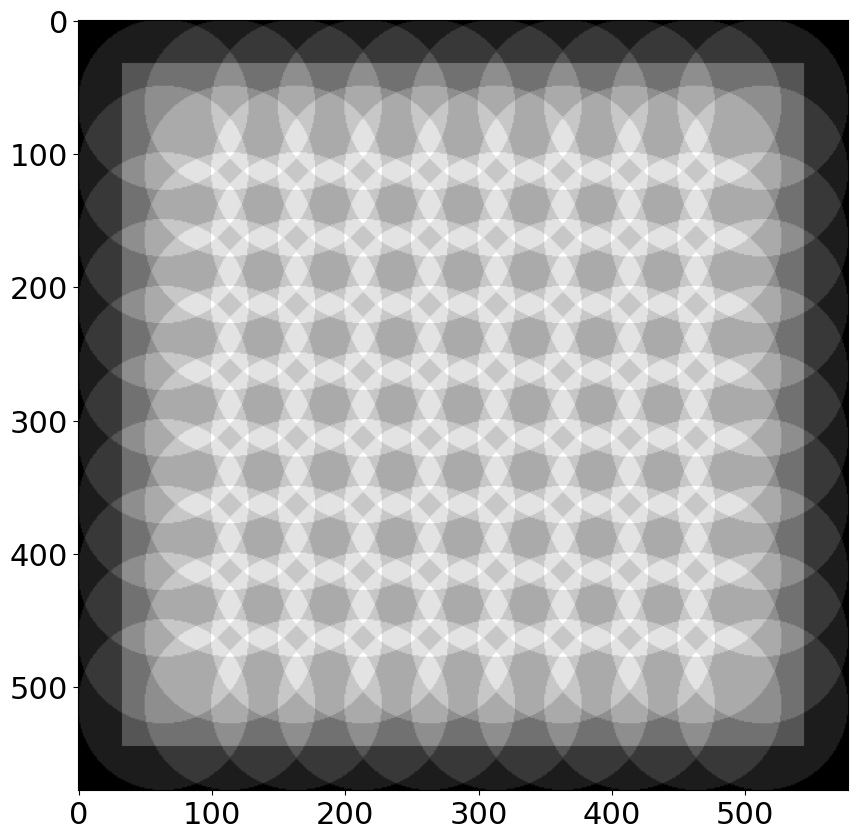

In [133]:
mesh = np.arange(0,input_dim + 2  * pad - measure_dim + 1,spacing)
xlocations,ylocations = np.meshgrid(mesh,mesh);
xlocations = xlocations.astype(int).flatten()
ylocations = ylocations.astype(int).flatten()
num_frame = len(mesh)**2

dim_measure = np.ones([num_frame],'int') * measure_dim
cam_locations = np.concatenate([xlocations.reshape([-1,1]),ylocations.reshape([-1,1])],1)

## pattern
pattern = np.zeros([input_dim + 2  * pad,input_dim + 2  * pad])
pattern[pad:input_dim + pad,pad:input_dim + pad] = 2
for i in range(len(dim_measure)):
    pattern[cam_locations[i,0]:cam_locations[i,0]+dim_measure[i],
            cam_locations[i,1]:cam_locations[i,1]+dim_measure[i]] += get_pupil(dim_measure[i])
plt.figure(figsize = (10,10))
plt.imshow(pattern,cmap='gray')
plt.savefig('fpApertures.pdf')

In [ ]:
pattern = np.zeros([input_dim + 2  * pad,input_dim + 2  * pad])
for i in range(len(dim_measure)):
    pattern[cam_locations[i,0]:cam_locations[i,0]+dim_measure[i],
            cam_locations[i,1]:cam_locations[i,1]+dim_measure[i]] += get_pupil(dim_measure[i])
pattern = np.maximum(1,pattern) ## ensure not divided by 0

## FP measurement

As illustrated above, the number of measurements is determined by the number of low pass windows needed to span the full Fourier space. Here we assume that apertures are translated by .39 aperture in each direction, in all about 4 measurements are made of every point in the fourier space.

In [ ]:
def get_measurement(im,photons,is_noisy,is_energy_constraint):
    X = np.zeros([num_frame,measure_dim,measure_dim])
    x = np.pad(np.fft.fftshift(np.fft.fft2(im.astype('complex128')))/input_dim,((pad,pad),(pad,pad)))
    if is_energy_constraint == True:
        x = x / np.sqrt(pattern)
    for i in range(num_frame):
        X[i,:,:] = np.abs(np.fft.ifft2(x[cam_locations[i,0]:cam_locations[i,0]+dim_measure[i],
                                        cam_locations[i,1]:cam_locations[i,1]+dim_measure[i]]* get_pupil(dim_measure[i]))) *np.sqrt(photons) * dim_measure[i]
    if is_noisy:
        X = np.sqrt(np.random.poisson(np.power(X,2)))
    return X/np.sqrt(photons)

We apply the Gerchberg Saxton error reduction technique iteratively for each subapeture to retrieve the image. The measurements are randomly shuffled to update a periodically. The iterative algorithm updates according to all the captured frames 100 times.


In [ ]:
def reconstruction(measure,is_energy_constraint):
    ## AP
    initial_image = cv2.resize(measure[np.int8(num_frame/2),:,:],(512,512))
    xest = np.pad(np.fft.fftshift(np.fft.fft2(initial_image.astype('complex128')))/input_dim,((pad,pad),(pad,pad)))
    order = list(range(num_frame))
    for iter_ in range(100):
        xest[0:pad,:] = 0
        xest[pad+512:pad*2 + 512,:] = 0
        xest[:,0:pad] = 0
        xest[:pad+512:pad*2 + 512] = 0
        random.shuffle(order)
        for im_idx in order:
            im = np.fft.ifft2(xest[cam_locations[im_idx,0]:cam_locations[im_idx,0]+dim_measure[im_idx],
                                   cam_locations[im_idx,1]:cam_locations[im_idx,1]+dim_measure[im_idx]]* get_pupil(dim_measure[im_idx]))
            im = measure[im_idx,:,:].astype('complex128') * np.exp(1j * np.angle(im))
            xest[cam_locations[im_idx,0]:cam_locations[im_idx,0]+dim_measure[im_idx],
                 cam_locations[im_idx,1]:cam_locations[im_idx,1]+dim_measure[im_idx]] = xest[cam_locations[im_idx,0]:cam_locations[im_idx,0]+dim_measure[im_idx],
                                                                                             cam_locations[im_idx,1]:cam_locations[im_idx,1]+dim_measure[im_idx]] * (1-get_pupil(dim_measure[im_idx])) + np.fft.fft2(im) / dim_measure[im_idx] * get_pupil(dim_measure[im_idx])
    if is_energy_constraint == True:
        estimate = np.fft.ifft2(np.fft.ifftshift(xest[pad:pad + input_dim,pad:pad + input_dim] * np.sqrt(pattern[pad:pad + input_dim,pad:pad + input_dim]))) * input_dim
    else:
        estimate = np.fft.ifft2(np.fft.ifftshift(xest[pad:pad + input_dim,pad:pad + input_dim])) * input_dim
    return estimate

## Error metrics

If $\underline{f}$ is an $N$-element optical field, and an estimate of this field is $\underline{f}_{\rm est}$.
One way to address this is to optimize the MSE over a global phase:
\begin{equation}
MSE = \underset{\psi}{argmin} \frac{1}{N} \left\| e^{j \psi} \underline{f} - \underline{f}_{\rm est} \right\|^2.
\end{equation}

In [9]:
def mse_loss(xest,y):
    error = abs(xest)**2 + abs(y)**2-2*np.abs(np.conjugate(xest)*y)
    return np.mean(error)

## Reconstruction vs noise per pixel

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

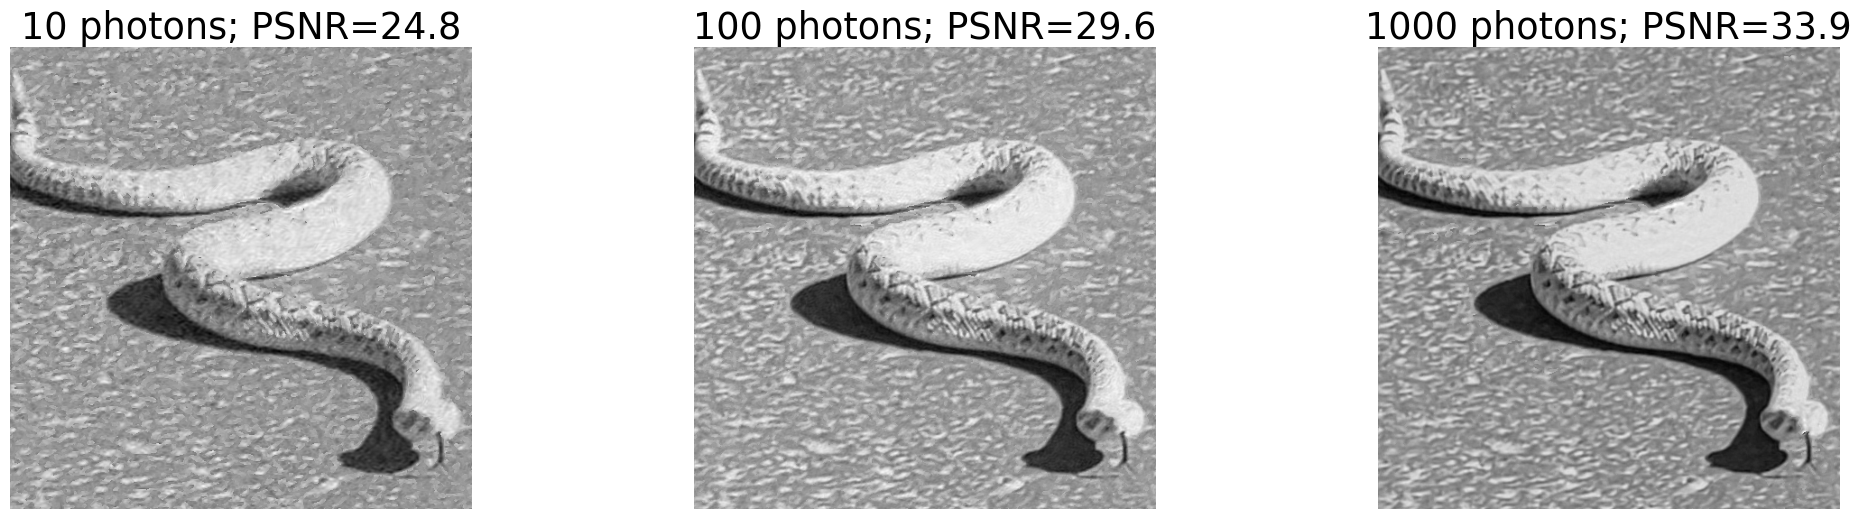

In [ ]:
# measurement
plt.figure(figsize= (25,6))
plt.rcParams.update({'font.size': 22})
for pip in range(3):
  measurement = get_measurement(im,photons = 10**(pip+1),is_noisy = True ,is_energy_constraint = False)

# Check energy
#print("Energy before / after:",np.sum(im**2),np.sum(measurement**2))

# reconstruction
  estimate = reconstruction(measurement,is_energy_constraint = False)
  rotation=np.mean(np.conjugate(estimate)*im/(np.abs(estimate)*np.abs(im)))
  plt.subplot(1,3,pip+1)
  plt.imshow(np.real(rotation*estimate),cmap='gray')
  plt.title(str(10**(pip+1))+' photons; PSNR={:.1f}'.format(10*np.log10(1/mse_loss(estimate,im))))
  plt.axis('off')
plt.savefig('fpRecon.pdf')
files.download('fpRecon.pdf')

# Wavefront cameras
April 2024

We consider measurement of a bandlimited wavefront using 9 measurements with shifted band filters on the original bandpass. The image consists of a $512\times 512$ element phasor. The image is low pass filtered by an aperture. The image is observed through shifted apetures to obtain a diversity of impulse responses. Error reduction phase retrieval is used to recover the image as function of the aperture shift. 100 iterations of the Gershberg Saxton algorithm are applied. Poisson noise is applied with approximately 10000 photons per image pixel. The error as a function of aperture shift is obtained.

In [183]:
input_dim = 512     # image dimension (512,512)
pad = 256+512    # Adding padding to the fourier space
dim_measure = 256  # radius of the aperture
spacing = 112  # of the aperture center in pixels
photons = 10000

### PSFs

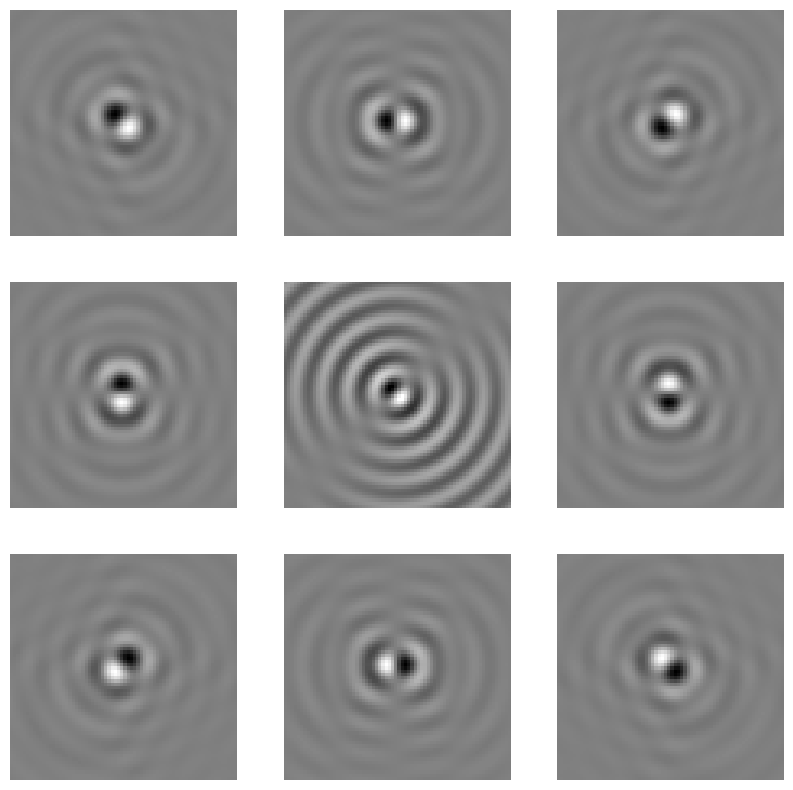

In [195]:
mesh = np.arange(-1,2)
mesh= np.int16(dim_measure+pad) + mesh * spacing
xlocations,ylocations = np.meshgrid(mesh,mesh);
xlocations = xlocations.astype(int).flatten()
ylocations = ylocations.astype(int).flatten()
num_frame = len(mesh)**2


cam_locations = np.concatenate([xlocations.reshape([-1,1]),ylocations.reshape([-1,1])],1)
plt.figure(figsize= (10,10))
## base filter
commonAperture = np.zeros([input_dim + 2  * pad,input_dim + 2  * pad])
filter = np.zeros([num_frame, input_dim + 2  * pad,input_dim + 2  * pad])
commonAperture[pad:input_dim + pad,pad:input_dim + pad] = get_pupil(2*dim_measure)
for i in range(9):
    filter[i, (cam_locations[i,0]-dim_measure):(cam_locations[i,0]+dim_measure),
            (cam_locations[i,1]-dim_measure):(cam_locations[i,1]+dim_measure)] += get_pupil(2*dim_measure)
    filter[i,:,:] = filter[i,:,:]*commonAperture
    psf=np.fft.fftshift(np.fft.fft2(np.fft.fftshift(filter[i,:,:])))
    plt.subplot(3,3,i+1)
    #plt.imshow(filter)
    plt.imshow(np.imag(psf[990:1060,990:1060]),cmap='gray')
    plt.axis('off')
plt.savefig('psf.pdf')


### apertures

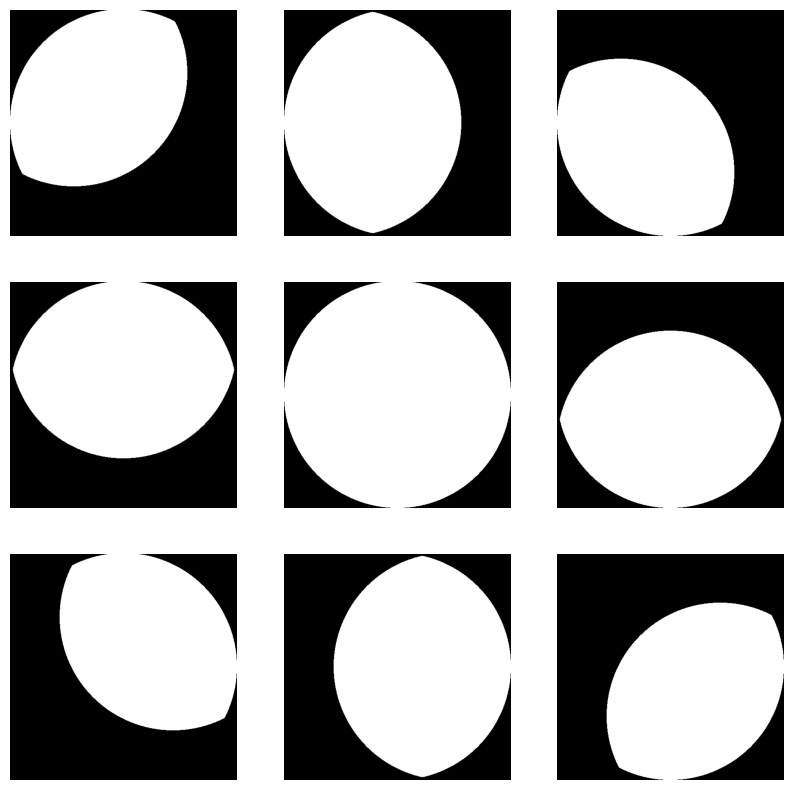

In [198]:
mesh = np.arange(-1,2)
mesh= np.int16(dim_measure+pad) + mesh * spacing
xlocations,ylocations = np.meshgrid(mesh,mesh);
xlocations = xlocations.astype(int).flatten()
ylocations = ylocations.astype(int).flatten()
num_frame = len(mesh)**2


cam_locations = np.concatenate([xlocations.reshape([-1,1]),ylocations.reshape([-1,1])],1)
plt.figure(figsize= (10,10))
## base filter
commonAperture = np.zeros([input_dim + 2  * pad,input_dim + 2  * pad])
filter = np.zeros([num_frame, input_dim + 2  * pad,input_dim + 2  * pad])
commonAperture[pad:input_dim + pad,pad:input_dim + pad] = get_pupil(2*dim_measure)
for i in range(9):
    filter[i, (cam_locations[i,0]-dim_measure):(cam_locations[i,0]+dim_measure),
            (cam_locations[i,1]-dim_measure):(cam_locations[i,1]+dim_measure)] += get_pupil(2*dim_measure)
    filter[i,:,:] = filter[i,:,:]*commonAperture
    psf=np.fft.fftshift(np.fft.fft2(np.fft.fftshift(filter[i,:,:])))
    plt.subplot(3,3,i+1)
    plt.imshow(filter[i,pad:(pad+input_dim),pad:(pad+input_dim)],cmap='gray')
    #plt.imshow(np.real(psf[975:1075,975:1075]),cmap='gray')
    plt.axis('off')
plt.savefig('apertures.pdf')

### Measurements

In [186]:
np.random.seed(0)
im=np.zeros([input_dim + 2  * pad,input_dim + 2  * pad]).astype('complex128')
im[pad:(pad+input_dim),pad:(pad+input_dim)]=(.5-np.random.rand(input_dim,input_dim))+1j*(.5-np.random.rand(input_dim,input_dim))
imF = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(im)))*filter[4,:,:]
im=np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(imF)))

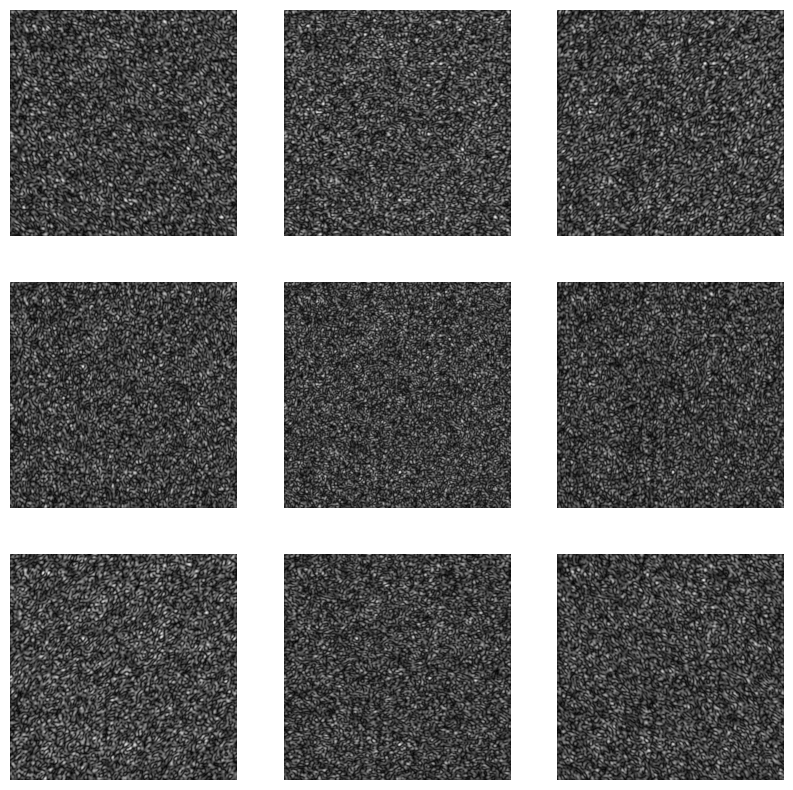

In [199]:
plt.figure(figsize= (10,10))
measurements=np.zeros([num_frame,input_dim + 2  * pad,input_dim + 2  * pad])
for i in range(9):
    measurements[i,:,:]=np.abs(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(filter[i,:,:]*imF))))
    measurements[i,:,:]=np.sqrt(np.random.poisson(photons*measurements[i,:,:]**2))/np.sqrt(photons)
    plt.subplot(3,3,i+1)
    plt.imshow(measurements[i,pad:(pad+input_dim),pad:(pad+input_dim)],cmap='gray')
    plt.axis('off')
plt.savefig('measurements.pdf')

## Reconstruction

In [188]:

xest = np.exp(2*np.pi*1j*np.random.random((2048,2048)))*measurements[4,:,:].astype('complex128')
fest=np.fft.fftshift(np.fft.fft2(np.fft.fftshift(xest)))
order = list(range(num_frame))
for iter_ in range(100):
      xest[0:pad,:] = 0
      xest[pad+512:pad*2 + 512,:] = 0
      xest[:,0:pad] = 0
      xest[:pad+512:pad*2 + 512] = 0
      random.shuffle(order)
      for im_idx in order:
        imP = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(filter[im_idx,:,:]*fest)))
        imP = measurements[im_idx,:,:].astype('complex128') * np.exp(1j * np.angle(imP))
        fest=(fest*(1-filter[im_idx,:,:])+filter[im_idx,:,:]*np.fft.fftshift(np.fft.fft2(np.fft.fftshift(imP))))*filter[4,:,:]
        xest=np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(fest)))


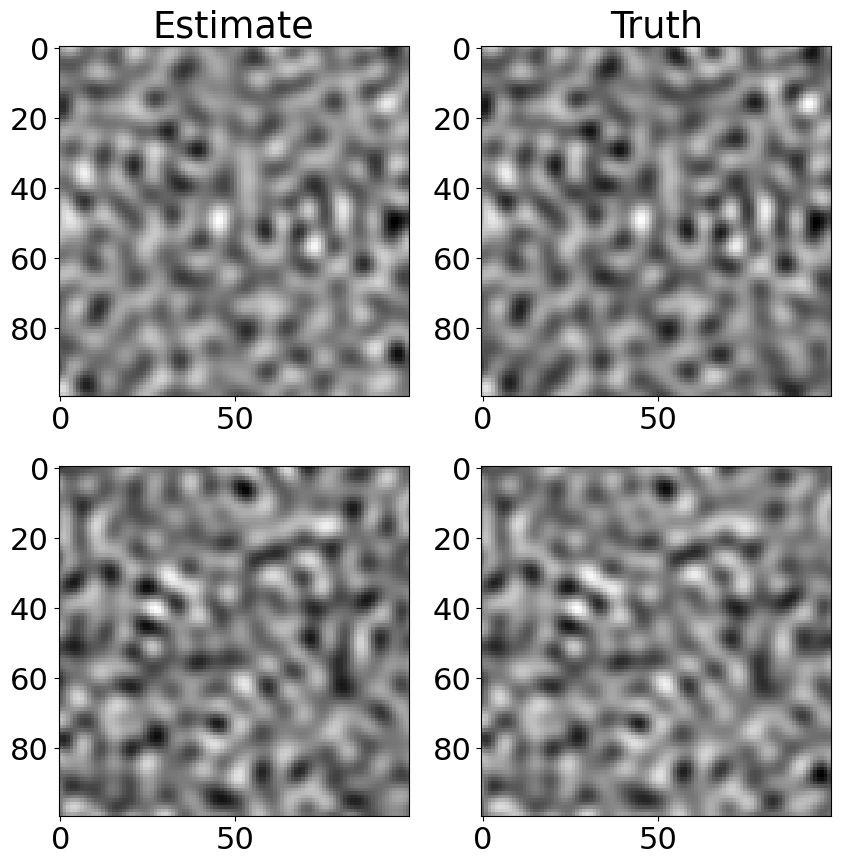

In [200]:
plt.figure(figsize= (10,10))
rotation=np.mean(np.conjugate(xest)*im/(np.abs(xest)*np.abs(im)))
plt.subplot(2,2,1)
plt.imshow(np.real((rotation*xest)[1000:1100,1000:1100]), cmap='gray')
plt.title('Estimate')
plt.subplot(2,2,2)
plt.imshow(np.real(im[1000:1100,1000:1100]), cmap='gray')
plt.title('Truth')
plt.subplot(2,2,3)
plt.imshow(np.imag((rotation*xest)[1000:1100,1000:1100]), cmap='gray')
plt.subplot(2,2,4)
plt.imshow(np.imag(im[1000:1100,1000:1100]), cmap='gray')
plt.savefig('reconstruction.pdf')

In [144]:
error16=mse_loss(xest,im)
print(error16)

1.4157414748654071e-05


In [156]:
error32=mse_loss(xest,im)
print(error32)

1.1305612411436134e-05


In [159]:
error48=mse_loss(xest,im)
print(error48)

6.056403867238923e-06


In [166]:
error64=mse_loss(xest,im)
print(error64)

4.694473647181589e-06


In [173]:
error80=mse_loss(xest,im)
print(error80)

2.883738784949509e-06


In [182]:
error96=mse_loss(xest,im)
print(error96)

2.1735933072544303e-06


In [190]:
error112=mse_loss(xest,im)
print(error112)

2.6602023856417944e-06


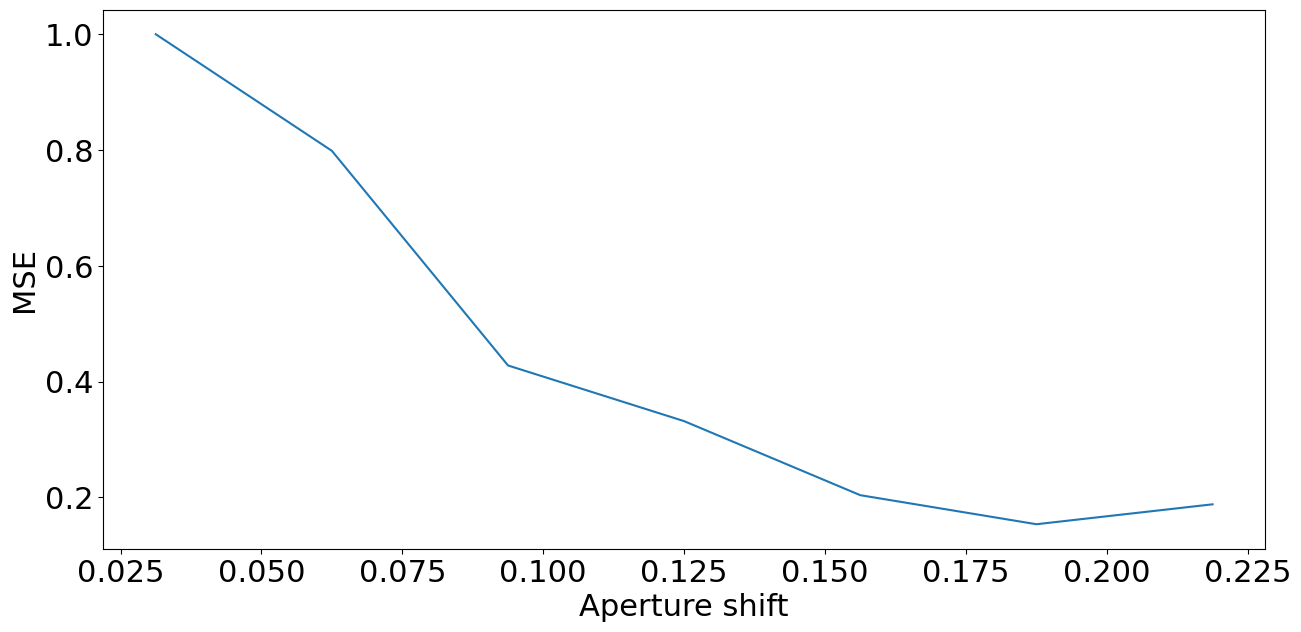

In [201]:
plt.figure(figsize= (15,7))
plt.plot(np.array([16,32,48,64,80,96,112])/512, np.array([error16,error32,error48,error64,error80,error96,error112])/error16)
plt.xlabel('Aperture shift')
plt.ylabel('MSE')
plt.savefig('wavecamMSE.pdf')